In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding, Bidirectional

from sklearn.metrics import classification_report, accuracy_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/russian-news/new_data.csv
/kaggle/input/final-data/final_data.csv


2024-06-09 12:57:14.287469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 12:57:14.287564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 12:57:14.412355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [16]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
df = pd.read_csv('/kaggle/input/final-data/final_data.csv')

In [ ]:
df.head(5)

# **Обработка текста**

In [3]:
cleaned_vectors = df['Vectors'].apply(lambda x: x.replace('\n', '').replace('[', '').replace(']', '').split())
cleaned_keywords_vectors = df['Vectors_keywords'].apply(lambda x: x.replace('\n', '').replace('[', '').replace(']', '').split())

In [4]:
X = (np.array([list(map(np.float_, vector)) for vector in cleaned_vectors])) 
y = df['Target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
df['Vectors_mean'] = [np.float_(vector) for vector in cleaned_vectors]
kernel = np.array([0.5, 0.25, 0.25])  
df['Vectors_mean'] = df['Vectors_mean'].apply(lambda x: np.convolve(x, kernel, mode='valid').mean())
print(df['Vectors_mean'])

0        0.029853
1        0.027660
2        0.028587
3        0.026409
4        0.028923
           ...   
12098    0.028765
12099    0.027389
12100    0.029616
12101    0.027707
12102    0.029612
Name: Vectors_mean, Length: 12103, dtype: float64


In [6]:
df['Target'] = 0

In [7]:
df.loc[df['Difference'] >= 3, 'Target'] = 1
df.loc[df['Difference'] <= -4, 'Target'] = -1

In [8]:
def clean_keywords(keywords_str):
    # Преобразование строки ключевых слов в список слов
    keywords_list = eval(keywords_str)  # Преобразуем строку в список с помощью eval
    
    # Фильтрация списка ключевых слов: оставляем только непустые слова
    cleaned_list = [word.strip() for word in keywords_list if word.strip()]
    
    return cleaned_list

# Применение функции clean_keywords к столбцу 'Keywords' и создание нового столбца 'Cleaned_Keywords'
df['Tokens'] = df['Tokens'].apply(clean_keywords)

In [9]:
import matplotlib.pyplot as plt

              precision    recall  f1-score   support

          -1       0.20      0.03      0.05        33
           0       0.92      0.99      0.95      1074
           1       0.84      0.35      0.49       104

    accuracy                           0.91      1211
   macro avg       0.65      0.46      0.50      1211
weighted avg       0.89      0.91      0.89      1211

Accuracy: 0.9099917423616846
[learning_curve] Training set sizes: [  72  871 1670 2468 3267 4066 4864 5663 6462 7261]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    6.5s remaining:   58.7s
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   31.2s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   40.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.3min remaining:   45.4s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.6min remaining:   29.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.0min remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


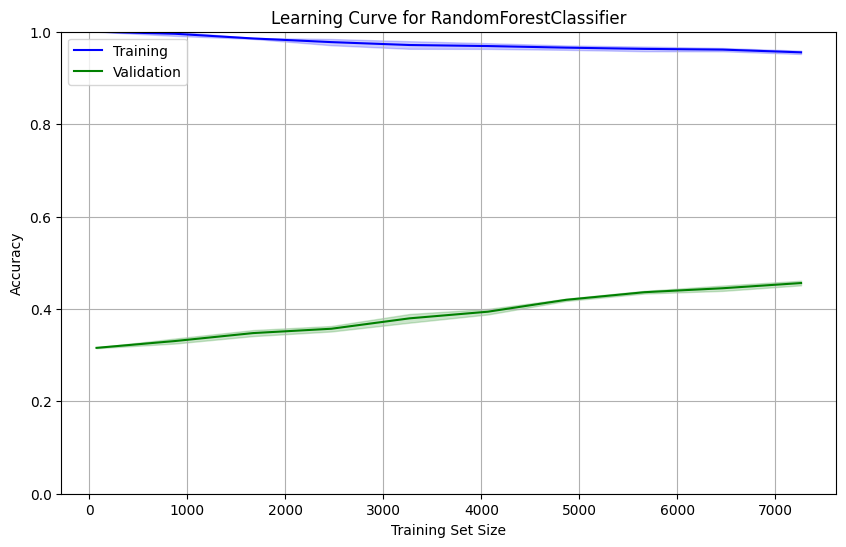

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import learning_curve

# Разделение данных на обучающий и тестовый наборы
X = (np.array([list(map(np.float_, vector)) for vector in cleaned_vectors]))   # Преобразование векторов в список
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Создание и обучение модели случайного леса
model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X_train, y_train)

# Оценка качества модели
pred = model.predict(X_test)
print(classification_report(y_test, pred))
print("Accuracy:", accuracy_score(y_test, pred))

train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, scoring='f1_macro', n_jobs=-1, verbose=10, shuffle=True
                                                      ,train_sizes=np.linspace(0.01, 1.0, 10), cv=3)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation', color='green')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)

plt.title('Learning Curve for RandomForestClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='best')
plt.grid()
plt.show()



150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400


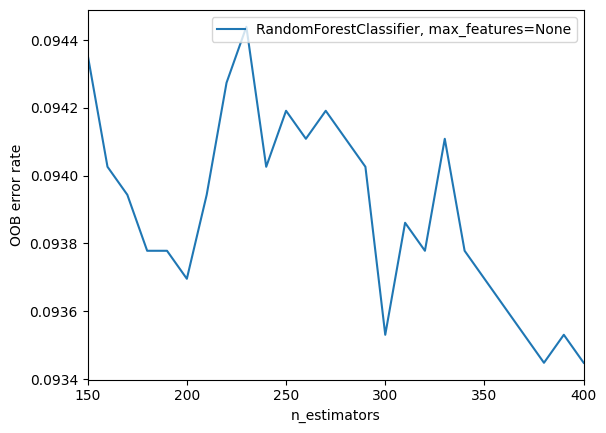

In [56]:
from collections import OrderedDict

ensemble_clfs = [
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=42,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 150
max_estimators = 400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 10):
        print(i)
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

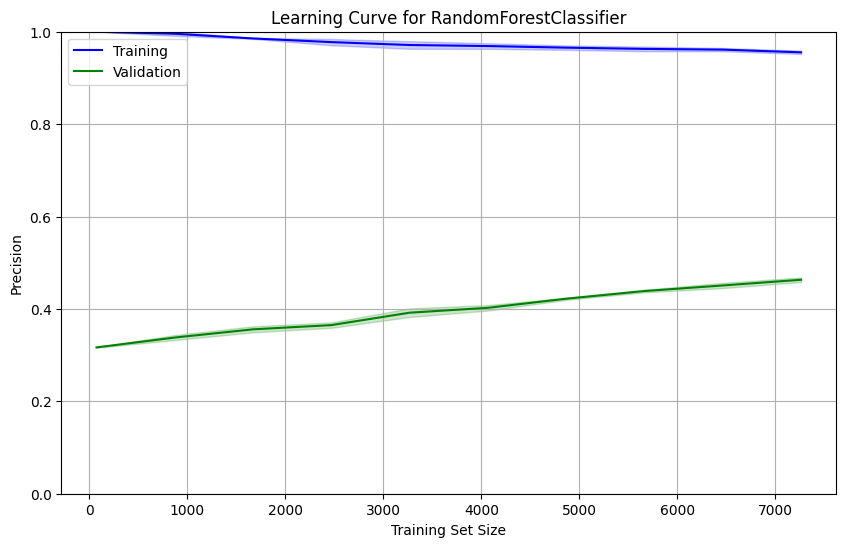

In [49]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.max(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation', color='green')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)

plt.title('Learning Curve for RandomForestClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('Precision')
plt.ylim(0, 1.0)
plt.legend(loc='best')
plt.grid()
plt.show()

# **XGBoost**

In [ ]:
def model_predict(clf, X_train,y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred))
    print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}")

In [ ]:
import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
#                         tree_method='gpu_hist', gpu_id=0, 
                        use_label_encoder=False,
                        subsample=0.8, nthread=10, learning_rate=0.01)
model_predict(clf, X_train, y_train+1, X_test, y_test+1)

# **LSTM**

In [6]:
def plot_history(history):
    accuracy = history.history['precision']
    val_accuracy= history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
# plot model architecture
def plot_model(model):
    model.summary()
    return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    )

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Предположим, что X и y уже определены, где y содержит метки классов 0, 1, 2

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование меток в формат one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

def build_model_1():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.25))
    model.add(Dense(526, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.Precision()],
                  optimizer=Adam(learning_rate=0.001))
    return model

# Создание и обучение модели
model = build_model_1()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Оценка модели
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))

In [ ]:
model_1 = build_model_1()
plot_model(model_1)

In [ ]:
history = model_1.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=16, 
    validation_split=0.1, # since the data dimension is big
    verbose=1, 
    shuffle=True
)

In [ ]:
X_train

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Предположим, что X и y уже определены, где y содержит метки классов 0, 1, 2

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование меток в формат one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)


def build_model_2():
    model = Sequential()
    model.add(LSTM(256, activation='sigmoid', return_sequences=True,
                 input_shape=(1,X_train.shape[1])
                 ))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.Precision()],
                  optimizer=Adam(learning_rate=0.001))
    return model

# Создание и обучение модели
model = build_model_2()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Оценка модели
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))


In [ ]:
model_lstm_1 = build_model_lstm()
plot_model(model_lstm_1)

In [ ]:
df.head(5)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def build_model_lstm_2():
    model = Sequential()
    model.add(Embedding(input_dim=(1,X_train.shape[1]), output_dim=300, input_shape=(max_len,)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))
    model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
            metrics=['precision'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [ ]:
model_lstm_2 = build_model_lstm_2()
plot_model(model_lstm_2)

In [ ]:
history = model_lstm_2.fit(df['Vectors'], df['Target'], epochs=30, validation_split=0.2)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Keywords'])
sequences = tokenizer.texts_to_sequences(df['Keywords'])
max_len = len(max(sequences, key=len))
padded_sequences = pad_sequences(sequences, maxlen=max_len)
history = model_lstm_2.fit(padded_sequences, df['Target'], epochs=30, validation_split=0.2)

In [ ]:
X_train.shape[0] / (2* (X_train.shape[1]+1))

In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [12]:
X = (np.array([list(map(np.float_, vector)) for vector in cleaned_vectors])) 
y = df['Target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [26]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование меток в формат one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [14]:
def build_model_lstm_3():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True),
                 input_shape=(len(X_train), 300))
                 )
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
            metrics=['precision'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [ ]:
y_train

In [15]:
model = build_model_lstm_3()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Оценка модели
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 300), dtype=float32). Expected shape (None, 9682, 300), but input has incompatible shape (None, 300)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 300), dtype=float32)
  • training=True
  • mask=None

In [13]:
import torch

In [8]:
def build_model_lstm_3():
    model = Sequential()
    model.add(Bidirectional(LSTM(16384, activation='relu', return_sequences=True), input_shape=(1, X_train.shape[2])))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(8192, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[2]))))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(4096, activation='relu')))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(loss=CategoricalFocalCrossentropy(reduction="sum"), metrics=['precision'], optimizer=Adam(learning_rate=0.0005))
    return model

In [14]:
model_lstm_3 = build_model_lstm_3()
plot_model(model_lstm_3)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

In [13]:
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 283s 17s/step - loss: 43.1750 - precision: 0.7919 - val_loss: 19.9048 - val_precision: 0.8978
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 271s 17s/step - loss: 21.8881 - precision: 0.8840 - val_loss: 18.5726 - val_precision: 0.8978
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 320s 17s/step - loss: 21.3008 - precision: 0.8854 - val_loss: 18.6761 - val_precision: 0.8978
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 271s 17s/step - loss: 21.3545 - precision: 0.8837 - val_loss: 18.6709 - val_precision: 0.8978
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 319s 17s/step - loss: 20.9703 - precision: 0.8862 - val_loss: 18.5009 - val_precision: 0.8978
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 270s 17s/step - loss: 21.2256 - precision: 0.8855 - val_loss: 18.5921 - val_precision: 0.8978
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 268s 17s/step - loss: 20.6901 - precision: 0.8863 - val_loss: 18.3744 - val_precision: 0.8978
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 269s 17s/step - loss: 21.1096 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


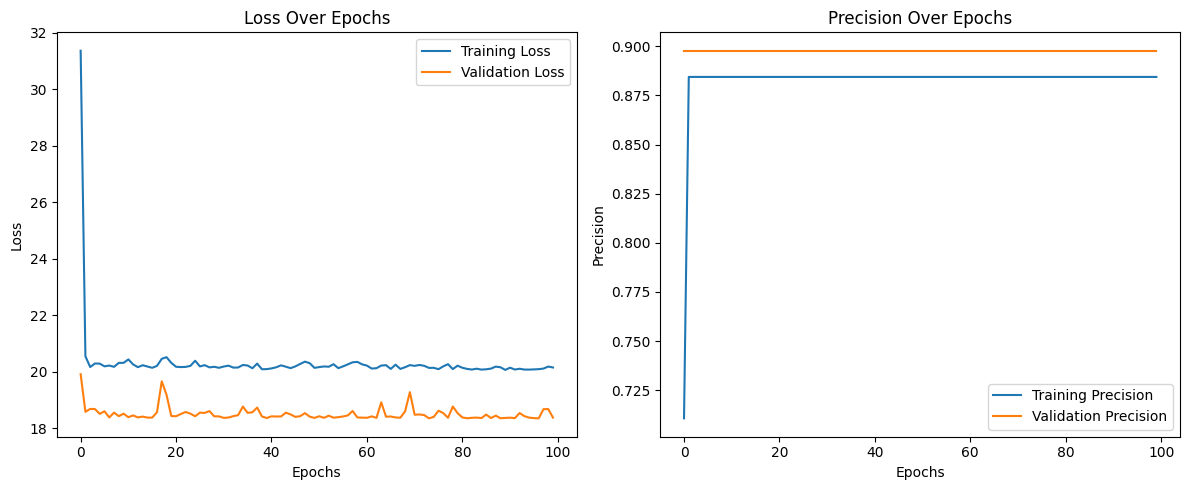

TypeError: Cannot clone object '<Sequential name=sequential_6, built=True>' (type <class 'keras.src.models.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.losses import CategoricalFocalCrossentropy

# Преобразование меток в формат one-hot encoding
#y = to_categorical(y, num_classes=3)

# Разделение данных на обучающий и тестовый наборы
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование входных данных в трехмерный тензор (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

def build_model_lstm_3():
    model = Sequential()
    model.add(Bidirectional(LSTM(4096, activation='relu', return_sequences=True), input_shape=(1, X_train.shape[2])))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(2048, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[2]))))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(1024, activation='relu')))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(loss=CategoricalFocalCrossentropy(reduction="sum"), metrics=['precision'], optimizer=Adam(learning_rate=0.0005))
    return model

# Создание и обучение модели
model = build_model_lstm_3()
#model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_split=0.2)

# Оценка модели
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))

plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, scoring='f1_macro'
                                                      ,train_sizes=np.linspace(0.8, 1.0, 15), cv=5)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation', color='green')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)

plt.title('Learning Curve for LSTM')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.ylim(0.2, 1.0)
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
sum(y_test_classes)

In [ ]:
import torch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
X_train

In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
model_lstm_3 = build_model_lstm_3()
plot_model(model_lstm_3)

In [ ]:
history = model_lstm_3.fit(
    X_train_reshaped, y_train, 
    epochs=20, 
    batch_size=64, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True,
    callbacks=[reduce_lr]
)

In [ ]:
y_test

In [ ]:
 ## xtest => test image
y_pred = model_lstm_3.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Разделение данных на обучающий и тестовый наборы
X = (np.array([list(map(np.float_, vector)) for vector in cleaned_vectors]))   # Преобразование векторов в список
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели случайного леса
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Оценка качества модели
pred = model.predict(X_test)
print(classification_report(y_test, pred))
print("Accuracy:", accuracy_score(y_test, pred))

In [ ]:
print(classification_report(y_test, y_pred

In [ ]:
df

# **BERT**

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Загрузка предварительно обученного токенизатора BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Токенизация и преобразование текста в тензоры
encoded_data = tokenizer(df['Text_preprocessed'].tolist(), padding=True, truncation=True, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
!ls /kaggle/input/

In [ ]:
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path('/kaggle/input/final-data')
print(f'GCS_DS_PATH = {GCS_DS_PATH}\n')

In [ ]:
!pip install gsutil

In [ ]:
!gsutil ls $GCS_PATH

In [ ]:
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)


In [ ]:
categories = df[['Target']].values.reshape(-1)

In [ ]:
def bert_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train = bert_encode(X_train, tokenizer)
X_test = bert_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
import tensorflow as tf

def build_model(n_categories):
    with strategy.scope():
        input_word_ids =  tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask =  tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids =  tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')
        
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)

        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        
        x = x[0]
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
with strategy.scope():
    model = build_model(3)
    model.summary()

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# **RUBERT**

In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_data = tokenizer(df['Text'].tolist(), padding=True, truncation=True, return_tensors='pt').to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


KeyboardInterrupt



In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
batch_size = 64 

labels = torch.tensor((df['Target']+1).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

train_data, test_data = train_test_split(dataset, train_size=0.7, shuffle=True)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Average Loss: {total_loss / len(train_dataloader)}')

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')

In [10]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('blanchefort/rubert-base-cased-sentiment', model_max_length=512)
encoded_data = tokenizer(df['Text'].tolist(), padding=True, return_tensors='pt', truncation=True).to(device)

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
encoded_data

{'input_ids': tensor([[  101, 19118, 74144,  ...,     0,     0,     0],
        [  101, 36916, 14052,  ...,     0,     0,     0],
        [  101,   304, 36686,  ...,     0,     0,     0],
        ...,
        [  101, 28257,  7997,  ...,     0,     0,     0],
        [  101,   436, 11558,  ...,     0,     0,     0],
        [  101, 19192, 17036,  ...,     0,     0,     0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Настройки
batch_size = 32
num_epochs = 50

model = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced').to(device)

labels = torch.tensor(df['Target'].tolist(), dtype=torch.long).to(device)

# Создание TensorDataset и DataLoader для тренировочной и тестовой выборок
dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=1e-5)

# Списки для хранения значений ошибок
train_losses = []
test_losses = []

# Обучение модели
model.train()
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')
    total_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Average Training Loss: {avg_train_loss}')
    
    # Оценка модели на тестовом наборе
    model.eval()
    total_test_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, batch_labels = batch
            outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
            loss = outputs.loss
            total_test_loss += loss.item()
            batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
            predictions.extend(batch_predictions)
            true_labels.extend(batch_labels.cpu().tolist())
    
    avg_test_loss = total_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    print(f'Average Test Loss: {avg_test_loss}')
    model.train()

# Построение кривых обучения
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Оценка модели на тестовом наборе
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1


/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [246,0,0], thread: [32,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [246,0,0], thread: [33,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [246,0,0], thread: [34,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [246,0,0], thread: [35,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [246,0,0], thread: [36,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [246,0,0], thread: [37,0,0] Assertion 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
import torch
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# **RUBERT**

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=512)
encoded_data = tokenizer(df['Text'].tolist(), padding=True, return_tensors='pt', truncation=True).to(device)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

# Преобразуем метки классов в тензор и переместим на устройство (GPU)
labels = torch.tensor((df['Target']+1).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

# Уменьшение размера пакета (batch size)
batch_size = 16 
# Создание DataLoader для обучения
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Обучение модели
model.train()
for epoch in range(20):
    print(f'Epoch {epoch + 1}')
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Average Loss: {total_loss / len(dataloader)}')

# Оценка результатов
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

# Оценка метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', model_max_length=512)
encoded_data = tokenizer(df['Vectors'].tolist(), padding=True, return_tensors='pt', truncation=True).to(device)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

# Преобразуем метки классов в тензор и переместим на устройство (GPU)
labels = torch.tensor((df['Target']+1).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

# Уменьшение размера пакета (batch size)
batch_size = 16 
# Создание DataLoader для обучения
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Обучение модели
model.train()
for epoch in range(20):
    print(f'Epoch {epoch + 1}')
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Average Loss: {total_loss / len(dataloader)}')

# Оценка результатов
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

# Оценка метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

# Преобразуем метки классов в тензор и переместим на устройство (GPU)
labels = torch.tensor((df['Target']+1).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

# Уменьшение размера пакета (batch size)
batch_size = 16 
# Создание DataLoader для обучения
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Обучение модели
model.train()
for epoch in range(20):
    print(epoch)
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Average Loss: {total_loss / len(dataloader)}')

# Оценка результатов
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

# Оценка точности модели
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')

# **RUBERT-SENTIMENT**

In [11]:
df['Tokens'] = [' '.join(lst) for lst in df['Tokens'].values]

In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', model_max_length=512)
encoded_data = tokenizer(df['Tokens'].tolist(), padding=True, return_tensors='pt', truncation=True).to(device)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

# Преобразуем метки классов в тензор и переместим на устройство (GPU)
labels = torch.tensor((df['Target']+1).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

# Уменьшение размера пакета (batch size)
batch_size = 16 
# Создание DataLoader для обучения
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Обучение модели
model.train()
for epoch in range(20):
    print(f'Epoch {epoch + 1}')
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Average Loss: {total_loss / len(dataloader)}')

# Оценка результатов
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

# Оценка метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

Epoch 1


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

# Преобразуем метки классов в тензор и переместим на устройство (GPU)
labels = torch.tensor((df['Target']+1).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

# Уменьшение размера пакета (batch size)
batch_size = 32
# Создание DataLoader для обучения
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Обучение модели
model.train()
for epoch in range(50):
    print(f'Epoch {epoch + 1}')
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Average Loss: {total_loss / len(dataloader)}')

# Оценка результатов
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

# Оценка метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


In [16]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', model_max_length=512)
encoded_data = tokenizer(df['Tokens'].astype(str).values.tolist(), padding=True, return_tensors='pt', truncation=True).to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [14]:
!pip install numpy --pre torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu117

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/nightly/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 71.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 GB 876.1 kB/s eta 0:00:000:0100:03
ERROR: Could not find a version that satisfies the requirement torchvision (from versions: none)
ERROR: No matching distribution found for torchvision


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Average Training Loss: 0.4730516976981175
Average Test Loss: 0.42033755798873146
Epoch 2
Average Training Loss: 0.40730957431171594
Average Test Loss: 0.4083676831306596
Epoch 3
Average Training Loss: 0.38841521203911344
Average Test Loss: 0.38813052208800064
Epoch 4
Average Training Loss: 0.36297122071875204
Average Test Loss: 0.3712601019559722
Epoch 5
Average Training Loss: 0.34284601154008715
Average Test Loss: 0.36749295370751306
Epoch 6
Average Training Loss: 0.32636774764104254
Average Test Loss: 0.3695896416902542
Epoch 7
Average Training Loss: 0.3079950309699715
Average Test Loss: 0.3695742571236272
Epoch 8
Average Training Loss: 0.2927357049984704
Average Test Loss: 0.3696465363333884
Epoch 9
Average Training Loss: 0.27048682072276725
Average Test Loss: 0.37423990706079885
Epoch 10
Average Training Loss: 0.2541771966582871
Average Test Loss: 0.3850076432879034
Epoch 11
Average Training Loss: 0.24151345388502768
Average Test Loss: 0.3889797772035787
Epoch 12
Average Tr

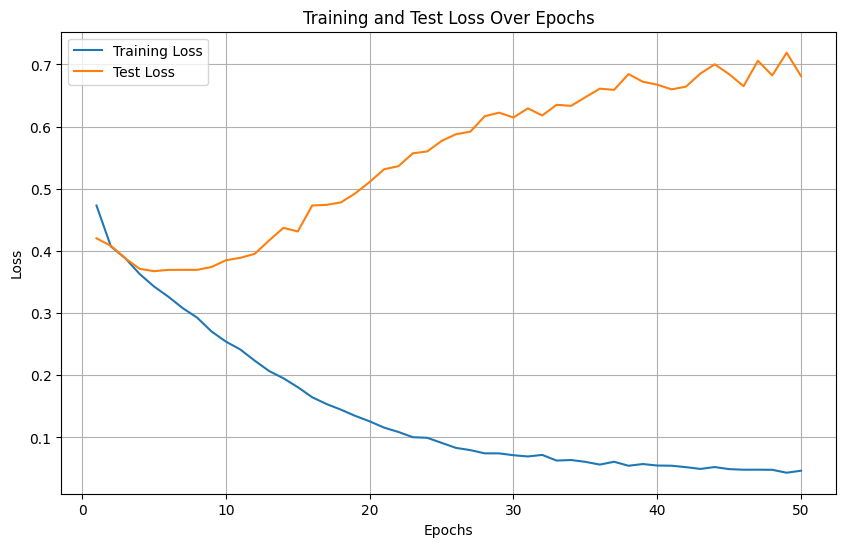

Accuracy: 0.8785625774473358
Precision: 0.5323069578708677
Recall: 0.48833494246761905
F1-score: 0.5064593699009733
Confusion Matrix:
[[   6   54    6]
 [  36 2028   72]
 [   3  123   93]]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Настройки
batch_size = 32
num_epochs = 50

# Загрузка токенизатора и модели
#tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced').to(device)

# Подготовка данных
#encoded_data = tokenizer(df['Tokens'].astype(str).values.tolist(), padding=True, return_tensors='pt', truncation=True).to(device)
labels = torch.tensor((df['Target']+1).tolist(), dtype=torch.long).to(device)

# Создание TensorDataset и DataLoader для тренировочной и тестовой выборок
dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=1e-5)

# Списки для хранения значений ошибок
train_losses = []
test_losses = []

# Обучение модели
model.train()
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')
    total_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Average Training Loss: {avg_train_loss}')
    
    # Оценка модели на тестовом наборе
    model.eval()
    total_test_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, batch_labels = batch
            outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
            loss = outputs.loss
            total_test_loss += loss.item()
            batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
            predictions.extend(batch_predictions)
            true_labels.extend(batch_labels.cpu().tolist())
    
    avg_test_loss = total_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    print(f'Average Test Loss: {avg_test_loss}')
    model.train()

# Построение кривых обучения
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Оценка модели на тестовом наборе
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


In [ ]:
vectors_tensor

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

# Преобразуем метки классов в тензор и переместим на устройство (GPU)
labels = torch.tensor((df['Target']).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

# Уменьшение размера пакета (batch size)
batch_size = 32
# Создание DataLoader для обучения
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Обучение модели
model.train()
for epoch in range(50):
    print(f'Epoch {epoch + 1}')
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Average Loss: {total_loss / len(dataloader)}')

# Оценка результатов
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

# Оценка метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', model_max_length=512)
encoded_data = tokenizer(df['Tokens'].astype(str).values.tolist(), padding=True, return_tensors='pt', truncation=True).to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Создание TensorDataset и DataLoader для тренировочной и тестовой выборок
labels = torch.tensor((df['Target']).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model.train()
for epoch in range(50):
    print(f'Epoch {epoch + 1}')
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Average Loss: {total_loss / len(dataloader)}')

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


In [ ]:
torch.cuda.is_available()

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', num_labels=3).to(device)

In [ ]:
from transformers import BertConfig
configuration = BertConfig(vocab_size = 29564, 
                           hidden_size = 512, 
                           intermediate_size = 600,
                           classifier_dropout = 0.2, 
                           _name_or_path = "cointegrated/rubert-tiny-sentiment-balanced",
                           architectures = "BertForSequenceClassification",
                           attention_probs_dropout_prob = 0.1,
                           emb_size = 312,
                           gradient_checkpointing = True,
                           hidden_act = 'gelu_new',
                           hidden_dropout_prob = 0.1,
                           id2label = {
                               "0": "negative",
                               "1": "neutral",
                               "2": "positive"},
                           initializer_range = 0.02,
                           label2id = {
                               "negative": 0,
                               "neutral": 1,
                               "positive": 2
                           },
                           layer_norm_eps = 1e-12,
                           max_position_embeddings = 512,
                           model_type = "bert",
                           num_attention_heads = 12,
                           num_hidden_layers = 3,
                           pad_token_id = 0,
                           position_embedding_type = "absolute",
                           problem_type = "single_label_classification",
                           torch_dtype = "float32",
                           transformers_version = "4.6.1",
                           type_vocab_size = 2,
                           use_cache = True)
model.config = configuration

In [ ]:
model.config

In [ ]:
df.columns

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', model_max_length=512)
encoded_data = tokenizer(df['Text_preprocessed'].astype(str).values.tolist(), padding=True, return_tensors='pt', truncation=True).to(device)

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

In [ ]:
# Применение функции к столбцу Tokens
df['Tokens'] = df['Tokens'].apply(lambda x: x.replace("'", "").replace("[", "").replace("]", "").replace(",", "").split())

In [ ]:
!pip install slovnet

In [ ]:
import torch
from slovnet.model.emb import NavecEmbedding
from navec import Navec


navec = Navec.load('/kaggle/working/navec_news_v1_1B_250K_300d_100q.tar')
emb = NavecEmbedding(navec)

max_length = max(len(tokens) for tokens in df['Tokens'])
ids = []
for tokens in df['Tokens']:
    token_ids = []
    for token in tokens:
        try:
            token_id = navec.vocab[token]
        except KeyError:
            token_id = 0  # Установка значения 0 в случае отсутствия слова в словаре
        token_ids.append(token_id)
    # Дополнение вектора нулями до максимальной длины
    token_ids += [0] * (max_length - len(token_ids))
    ids.append(token_ids)
#input = torch.tensor(ids)
#output = emb(input)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
input = torch.tensor(ids)
emb.to(device)
output = emb(ids_tensor)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoded_data = torch.tensor((df['Vectors']).tolist(), dtype=torch.long).to(device)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

In [ ]:
 torch.cuda.is_available()

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', model_max_length=512)
encoded_data = tokenizer(df['Tokens'].astype(str).values.tolist(), padding=True, return_tensors='pt', truncation=True).to(device)

In [ ]:
encoded_data

In [ ]:
df['Target'].value_counts()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split

model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-sentiment-balanced', num_labels=3).to(device)

labels = torch.tensor((df['Target']+1).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

train_data, test_data = train_test_split(dataset, train_size=0.7, shuffle=True)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=1e-5)

# Обучение модели
model.train()
for epoch in range(30):
    print(f'Epoch {epoch + 1}')
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Average Loss: {total_loss / len(train_dataloader)}')

# Оценка результатов
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

# Оценка метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased')
encoded_data = tokenizer(df['Text_preprocessed'].tolist()).to(device)

In [ ]:
!pip show AutoTokenizer

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
batch_size = 32
# Преобразуем метки классов в тензор и переместим на устройство (GPU)
labels = torch.tensor((df['Target']).tolist(), dtype=torch.long).to(device)

dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], labels)

train_data, test_data = train_test_split(dataset, train_size=0.7, shuffle=True)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Уменьшение размера пакета (batch size)
batch_size = 16 
# Создание DataLoader для обучения

# Обучение модели
model.train()
for epoch in range(3):
    print(epoch)
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Average Loss: {total_loss / len(train_dataloader)}')

# Оценка результатов
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, batch_labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)
        true_labels.extend(batch_labels.cpu().tolist())

# Оценка точности модели
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')

In [ ]:
!pip install GPUtil 

In [ ]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()           

In [ ]:
import os
os.environ["TORCH_USE_CUDA_DSA"] = "true"

In [ ]:
import gc
gc.collect()